## Importing the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.utils import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding, MaxPooling1D, Flatten, Dense, Conv1D, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.layers import Dropout

## Importing variables from the preprocessing notebook as csv files


In [3]:
y = np.loadtxt('y.csv', delimiter=',')
X = pd.read_csv('X.csv')

In [4]:
# Explore the distribution of sequence lengths
sequence_lengths = X['preprocessed_text'].apply(lambda x: len(x.split()))

# Calculate the 95th percentile
percentile_95 = np.percentile(sequence_lengths, 95)

# Set max_length slightly higher than the 95th percentile
max_length = int(percentile_95 * 1.1)

print("Chosen Max Length:", max_length)

Chosen Max Length: 158


In [5]:
# Build a vocabulary from your text data
all_text = ' '.join(X['preprocessed_text'].tolist())
unique_words = set(all_text.split())
vocab_size = len(unique_words) + 1

print("Vocabulary Size:", vocab_size)

Vocabulary Size: 23637


In [6]:
X = X['preprocessed_text']
X = [str(x) for x in X]

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=max_length)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Hyper parameter Tuning

In [17]:
# Define a function to create the CNN model
def create_model(embedding_dim=50, filters=100, kernel_size=3, pool_size=2, dense_units=64, dropout_rate=0.0):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))  # Corrected parameter name
    model.add(Dropout(rate=dropout_rate))  # Corrected parameter name
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the grid of hyperparameter values to search
param_grid = {
    'embedding_dim': [50, 100],
    'filters': [64, 128],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'dense_units': [64, 128],
    'dropout_rate': [0.0, 0.5]
}

# Create a KerasClassifier based on the function
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)
# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

In [ ]:
# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy
print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_}')

## CNN Model

In [7]:
# Create a Sequential model
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

# Add Convolutional layers
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten layer
model.add(Flatten())

# Add Fully Connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

In [8]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 50)           1240500   
                                                                 
 conv1d (Conv1D)             (None, 154, 64)           16064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 77, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4928)              0         
                                                                 
 dense (Dense)               (None, 64)                315456    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [10]:
# Train the model and store the history
history_cnn = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
178/178 [==============================] - 9s 46ms/step - loss: 0.4029 - accuracy: 0.8182 - val_loss: 0.2690 - val_accuracy: 0.9154
Epoch 2/10
178/178 [==============================] - 10s 54ms/step - loss: 0.1537 - accuracy: 0.9485 - val_loss: 0.2065 - val_accuracy: 0.9217
Epoch 3/10
178/178 [==============================] - 10s 54ms/step - loss: 0.0629 - accuracy: 0.9838 - val_loss: 0.2167 - val_accuracy: 0.9245
Epoch 4/10
178/178 [==============================] - 8s 44ms/step - loss: 0.0357 - accuracy: 0.9933 - val_loss: 0.2714 - val_accuracy: 0.9274
Epoch 5/10
178/178 [==============================] - 9s 51ms/step - loss: 0.0225 - accuracy: 0.9986 - val_loss: 0.3306 - val_accuracy: 0.9267
Epoch 6/10
178/178 [==============================] - 8s 47ms/step - loss: 0.0173 - accuracy: 0.9991 - val_loss: 0.3474 - val_accuracy: 0.9344
Epoch 7/10
178/178 [==============================] - 9s 51ms/step - loss: 0.0163 - accuracy: 0.9996 - val_loss: 0.3676 - val_accuracy: 0.93

## Model Evaluation on Training and Validation Data

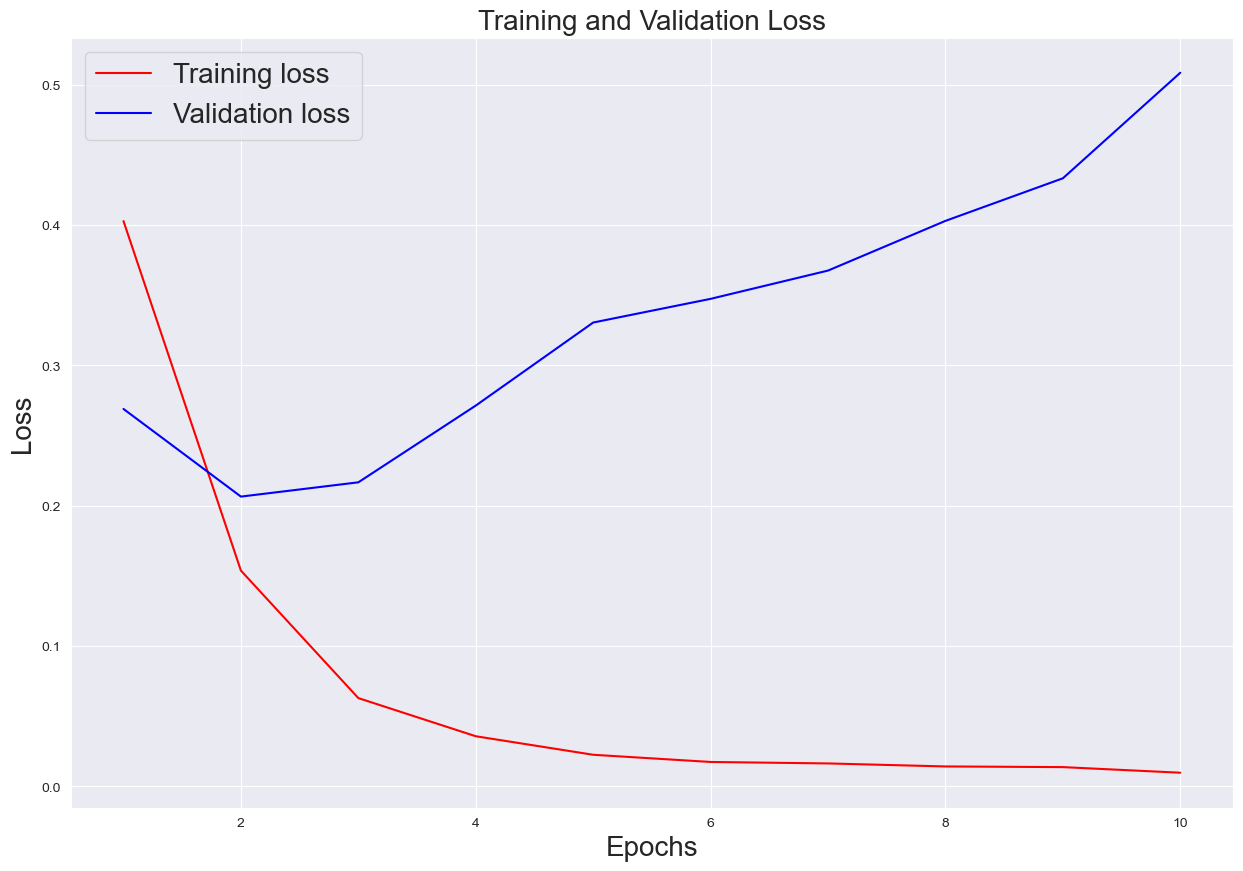

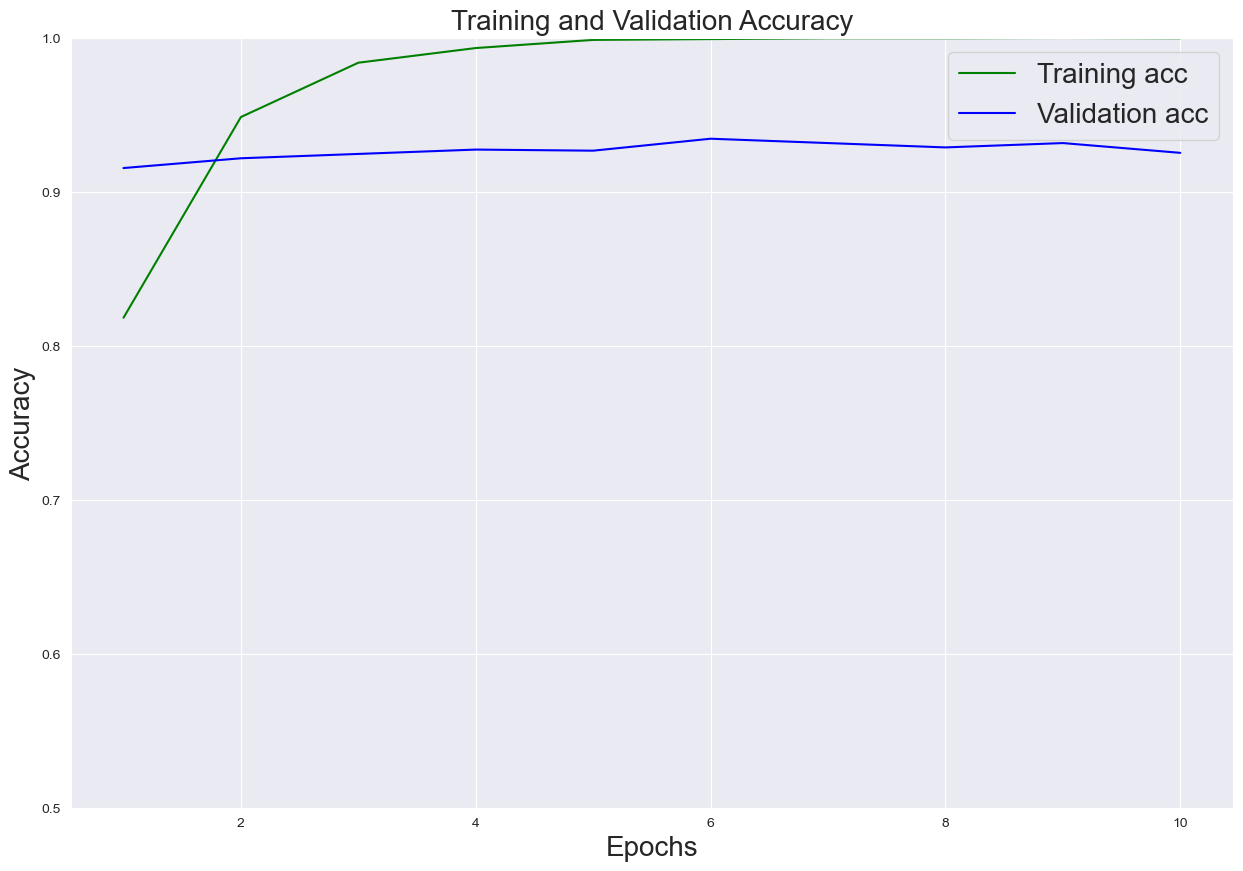

In [11]:
# Extract training history
history_cnn_dict = history_cnn.history

# Extract metrics
acc_cnn = history_cnn_dict['accuracy']
val_acc_cnn = history_cnn_dict['val_accuracy']
loss_cnn = history_cnn_dict['loss']
val_loss_cnn = history_cnn_dict['val_loss']
epochs_cnn = range(1, len(acc_cnn) + 1)

# Plot training and validation loss
plt.figure(figsize=(15, 10))
plt.plot(epochs_cnn, loss_cnn, 'r', label='Training loss')
plt.plot(epochs_cnn, val_loss_cnn, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(15, 10))
plt.plot(epochs_cnn, acc_cnn, 'g', label='Training acc')
plt.plot(epochs_cnn, val_acc_cnn, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Model Evaluation on Test Data

In [12]:
# Evaluate the model on the test data
evaluation = model.evaluate(X_test, y_test)

# Extract the evaluation metrics
loss, accuracy = evaluation

56/56 [==============================] - 1s 12ms/step - loss: 0.5567 - accuracy: 0.9255


In [13]:
# Get model predictions on the test data
y_pred_probs  = model.predict(X_test)

# Apply a threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

56/56 [==============================] - 1s 18ms/step
Loss: 0.5567445158958435
Accuracy: 0.9255079030990601
Precision: 0.9500356887937188
Recall: 0.955491744436468
F1-Score: 0.952755905511811


## Classification Report

In [14]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82       379
         1.0       0.95      0.96      0.95      1393

    accuracy                           0.93      1772
   macro avg       0.89      0.89      0.89      1772
weighted avg       0.92      0.93      0.93      1772


## Confusion Matrix

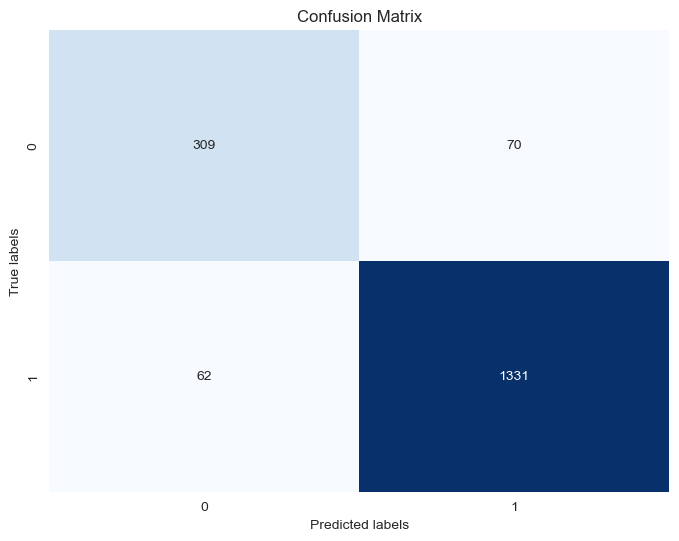

In [15]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()